# D-Wave and its ecosystem

Following notebook will dig deeper into the existing tools that D-Wave and its ecosystem enables when tackling combinatorial problems.

For this exercises following libraries will be used: [PyQubo](https://pyqubo.readthedocs.io/en/latest/) as well as _dimod_ and _dwave-ocean-sdk_ from the DWave [Ocean suite](https://docs.ocean.dwavesys.com/en/stable/index.html)

Often the installation of the SDK already installs the other two dependencies, but just in case make sure all are present.

In [1]:
import dimod

h = {1: 1, 2: 1}
J = {(1, 2): 1}

dimod.ising_to_qubo(h, J, 0.5)

({(1, 1): 0.0, (2, 2): 0.0, (1, 2): 4.0}, -0.5)

PyQubo offers a simple way to come up with those formulations, express them in a simple way and then materialize the QUBO matrix or Ising coefficients.

## Portfolio optimization

Portfolio optimization is a simple exercise that matches pretty nicely the type of formulation we would like to produce. Comes from the definition of Markowitz's seminal work.

$$
\max \sum_i r_ix_i - \sum_i \sum_j c_{ij}x_ix_j \\
\text{ s. t. } \sum_i b_ix_i \le B
$$

where $r_i$ represents the return of an asset, the $c_{ij}$ is the risk of both assets being driven by the same factors. We should diversify when it comes to investment portfolios. $b_i$ is the cost of investing in an asset and $B$ is all the budget you have.

**QUBO**

\begin{equation}
\begin{split}
\min_{x_{i}\in{\{0,1\}}} \;\; & \theta_{1}\sum_{i=1}^{n}-x_{i}r_i \\
\;\;  +\;&\theta_{2}\sum_{i,j=1}^{n}x_{i}x_{j}c_{ij} \\
 +\;&\theta_{3}\left(\sum_{i=1}^{n}x_{i}b_{i}-B\right)^{2}
\end{split}
\end{equation}


The parameters $0\leq\theta_{1},\theta_{2},\theta_{3}<\infty$ represent the relative importance of each term to the decision maker, and she is free to change these parameters to best reflect that.

Let's select a set of assets and their potential (revenue and covariance).

In [2]:
import numpy as np

r_i = np.array([77.60417796, 29.71772711, 19.06733564, 32.14568747, 95.12069674, 32.7466954 , 56.48788447])

b_i = np.array([75, 23, 20, 33, 95, 29 , 25])

B = sum(b_i)*0.66

c_ij = np.array([[162.22030329,  16.96480901,  53.33392587, -61.19096975, -21.76232416, -93.48033116,  19.59907177],
                 [ 16.96480901,  69.33332072,  16.523284  ,  10.15842664, -10.78956293,  24.00854339, -14.78713228],
                 [ 53.33392587,  16.523284  ,  43.90334576, -11.43885741, -21.68843841, -22.09673565,  -5.10928035],
                 [-61.19096975,  10.15842664, -11.43885741,  46.42412482, -2.8970541 ,  49.90788498, -31.74061021],
                 [-21.76232416, -10.78956293, -21.68843841,  -2.8970541 , 23.59596426,   4.87211145,  16.74718009],
                 [-93.48033116,  24.00854339, -22.09673565,  49.90788498, 4.87211145,  81.35591517, -26.58473057],
                 [ 19.59907177, -14.78713228,  -5.10928035, -31.74061021, 16.74718009, -26.58473057,  40.90234169]])

In [3]:
from pyqubo import Array, Placeholder, Constraint

num_assets = len(r_i)
x = Array.create('x', shape=num_assets, vartype='BINARY')

In [4]:
# Profit generated by each asset individually
H_linear_profit = 0.0
for i in range(num_assets):
    H_linear_profit += Constraint(
        r_i[i] * x[i], label='profit({})'.format(i)
    )

In [5]:
# Risk obtained from the covariance matrix
H_quadratic = 0.0
for i in range(num_assets):
    for j in range(i + 1, num_assets):
        H_quadratic += Constraint(
            c_ij[i][j] * x[i] * x[j], label='risk({}, {})'.format(i, j)
        )

In [6]:
# Constraint (budget)
H_linear_budget = 0.0
for i in range(num_assets):
    H_linear_budget += Constraint(b_i[i]*x[i], label='slot({})'.format(i))

In [7]:
# Build model.
theta1 = Placeholder('theta1')
theta2 = Placeholder('theta2')
theta3 = Placeholder('theta3')
H = - theta1*H_linear_profit + theta2 * H_quadratic + theta3 * (H_linear_budget - B)**2
model = H.compile()

Data comes already in the model but we can select and play around with the regularization parameters to find a good balance in case of having no intuition by all means.

In [8]:
# Set the Lagrange multipliers
theta1=0.5 
theta2=0.3
theta3=0.2
feed_dict = {'theta1': theta1, 'theta2' : theta2, 'theta3' : theta3}

# Transform to QUBO.
qubo, offset = model.to_qubo(feed_dict=feed_dict)

In [9]:
import dimod

sampler = dimod.ExactSolver()

response = sampler.sample_qubo(qubo)

print(response.slice(10))

  x[0] x[1] x[2] x[3] x[4] x[5] x[6]       energy num_oc.
0    1    1    1    1    0    1    1 -7977.664565       1
1    1    0    0    0    1    1    0 -7976.446948       1
2    0    1    1    1    1    0    1 -7972.776279       1
3    0    0    1    1    1    1    1 -7970.392709       1
4    1    0    0    1    1    0    0 -7963.990385       1
5    0    1    1    0    1    1    1 -7961.841598       1
6    1    1    0    1    0    1    1 -7953.494598       1
7    1    0    0    0    1    0    1 -7949.231201       1
8    0    1    0    1    1    1    1 -7948.440829       1
9    1    1    0    0    1    0    0 -7941.697424       1
['BINARY', 10 rows, 10 samples, 7 variables]


In [10]:
solution = []
for k,v in response.first.sample.items():
    solution.append(v)

In [11]:
e_cost = np.round(np.sum(np.multiply(b_i,solution)),2)
print(f'The effective cost of this investment is {e_cost} for the budget limit of {B}')

The effective cost of this investment is 205 for the budget limit of 198.0


Seems like a hard problem to be solved. Most of the energy values are really close around the global optima. Play around with the regularization parameters to check the difference in results.

Now we can take our example to D-Wave's samples and see what we get. Make sure you copy your token into the code below.

In [ ]:
import minorminer
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite

# Instanciate Sampler
dwave_sampler = DWaveSampler(token="<your-token>")

# Construct a problem
bqm = dimod.BinaryQuadraticModel(qubo, dimod.BINARY)

# Get the edge list
target_edgelist = dwave_sampler.edgelist

# And source edge list on the BQM quadratic model
source_edgelist = list(bqm.quadratic)

# Find the embeding
embedding = minorminer.find_embedding(source_edgelist, target_edgelist)
sampler = FixedEmbeddingComposite(dwave_sampler, embedding)

In [14]:
# DWave sampler parameters
amode = 'histogram'
allowed_ta = dwave_sampler.properties['annealing_time_range'] #microsecond
num_reads=100

In [15]:
ta = 10 # microseconds
response = sampler.sample_qubo(qubo, num_reads=num_reads, annealing_time=ta, answer_mode=amode)

In [16]:
print(response.slice(10))

  x[0] x[1] x[2] x[3] x[4] x[5] x[6]       energy num_oc. chain_b.
0    1    1    1    1    0    1    1 -7977.664565       4      0.0
1    1    0    0    0    1    1    0 -7976.446948       1 0.142857
2    1    0    0    0    1    1    0 -7976.446948       5      0.0
3    0    1    1    1    1    0    1 -7972.776279       3      0.0
4    0    0    1    1    1    1    1 -7970.392709       1      0.0
5    1    0    0    1    1    0    0 -7963.990385       5      0.0
6    0    1    1    0    1    1    1 -7961.841598       2      0.0
7    1    1    0    1    0    1    1 -7953.494598       2      0.0
8    1    0    0    0    1    0    1 -7949.231201       3      0.0
9    1    1    0    0    1    0    0 -7941.697424       6      0.0
['BINARY', 10 rows, 32 samples, 7 variables]


You will see D-Wave already provides a lot of information about how to implement some of those canonical examples we went through previously.

* [D-Wave examples](https://github.com/dwave-examples)

## Max Cut

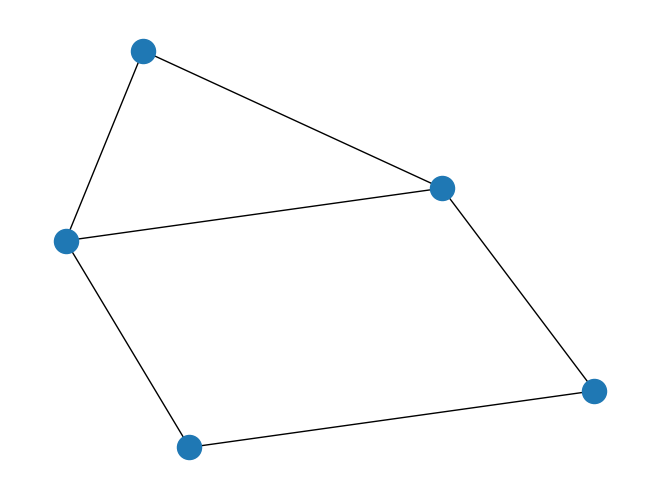

In [17]:
import networkx as nx

# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])

nx.draw(G)

In [18]:
from collections import defaultdict

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for i, j in G.edges:
    Q[(i,i)]+= -1
    Q[(j,j)]+= -1
    Q[(i,j)]+= 2

In [ ]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

# Set up QPU parameters
chainstrength = 8
numruns = 10

# Run the QUBO on the solver from your config file
sampler = EmbeddingComposite(DWaveSampler(token="<your-token>"))
response = sampler.sample_qubo(Q,
                               chain_strength=chainstrength,
                               num_reads=numruns,
                               label='Example - Maximum Cut')

In [21]:
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for sample, E in response.data(fields=['sample','energy']):
    S0 = [k for k,v in sample.items() if v == 0]
    S1 = [k for k,v in sample.items() if v == 1]
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

------------------------------------------------------------
          Set 0          Set 1    Energy        Cut Size    
------------------------------------------------------------
         [2, 3]      [1, 4, 5]     -5.0             5       
         [1, 4]      [2, 3, 5]     -5.0             5       


A pretty important piece of information here is that even though we started with $2^N$ potential solutions, finally we only got 4 that yield the same energy value. Therefore, our quantum state is the superposition of all those optimal solutions, therefore the ground state.

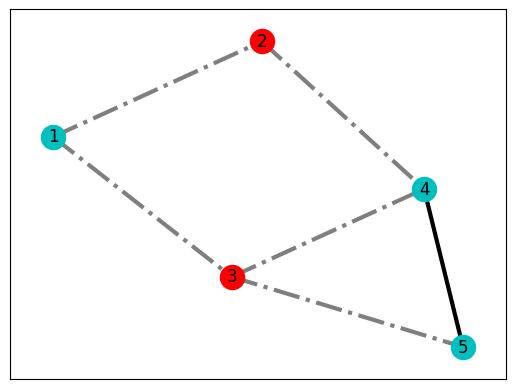

In [26]:
from matplotlib import pyplot as plt

lut = response.first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos);